# 4. Downscaling de Dados Locais e Dados do CMIP6

```python
Esse caderno tem como objetivo a obtenção da precipitação futura de dados locais 
para os pontos definidos nos GCMs do CMIP6 a partir de predição.
```

In [137]:
import os
import joblib
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from geopy.distance import geodesic
from IPython.display import clear_output

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error
)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor
)

from sklearn.linear_model import LinearRegression

from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import (
    Conv1D,
    LSTM,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout
)

## 4.1. Configurações

In [138]:
# Definição de se vai ocorrer ou não a geração de bases de dados
databases_generate = False

# Definição de se vai ocorrer ou não o a geração e o uso do método IDW
idw_method = True
idw_generate = False

# Tipo de base de dados local utilizada ('sum' ou 'max')
database_type = 'sum'

## 4.2. Funções

### 4.2.1. Função para Limeza de Terminal e Células

In [139]:
def clear():
    '''
    Função para limpar terminal ou célula
    '''

    # Limpando terminal
    # os.system('cls')

    # Limpando célula
    clear_output(wait=True)

### 4.2.2. Função para fixar Seed

In [140]:
def fix_seed(seed):
    '''
    Fixa seed informada
    '''

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

### 4.2.3. Predição a partir de Modelos de Machine Learning

In [141]:
def predicao_por_ml(df: pd.DataFrame,
                    col_de_treino: list[str],
                    var_de_predicao: str,
                    anos_X: tuple,
                    anos_Y: tuple):

    # Definição dos modelos
    models = [

        ("ExtraTrees", ExtraTreesRegressor(
            n_estimators=15,
            max_depth=20,
            max_features=2,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=7
        )),

        ("RandomForest", RandomForestRegressor(
            n_estimators=15,
            max_depth=25,
            max_features=2,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=7
        )),

        ("GradientBoosting", GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            random_state=7
        )),

        ("KNeighbors", KNeighborsRegressor(
            n_neighbors=7,
            weights='distance',
            algorithm='auto'
        )),

    ]

    best_model = ['', 0]

    models_infos = []

    for model in models:

        # Lista de métricas por modelo
        r_list, rmse_list, mae_list = [], [], []

        for i in range(len(anos_X)):

            ano_X_inicial, ano_X_final = anos_X[i]
            ano_y_inicial, ano_y_final = anos_Y[i]

            df_treino = df[(df['ano'] >= ano_X_inicial) & (df['ano'] <= ano_X_final)].copy()
            df_teste  = df[(df['ano'] >= ano_y_inicial) & (df['ano'] <= ano_y_final)].copy()

            X_train = df_treino[col_de_treino]
            y_train = df_treino[var_de_predicao]

            X_test = df_teste[col_de_treino]
            y_test = df_teste[var_de_predicao]

            model[1].fit(X_train, y_train)
            y_pred = model[1].predict(X_test)

            r_list.append(np.corrcoef(y_test, y_pred)[0, 1])  # r
            rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))  # RMSE
            mae_list.append(mean_absolute_error(y_test, y_pred))

        if np.mean(r_list) >= best_model[1]:
            best_model[0] = model[1]
            best_model[1] = np.mean(r_list)

        # print(f"{model[0][:3]} \t Média r: {np.mean(r_list):.4f} \t Média RMSE: {np.mean(rmse_list):.4f}")

        models_infos.append((model[0], np.mean(r_list), np.mean(rmse_list), np.mean(mae_list)))

    # return (best_model[0], best_model[1])

    return models_infos

### 4.2.4. Predição a partir de Modelos de Deep Learning

In [142]:
def predicao_por_cnn(df: pd.DataFrame,
                     col_de_treino: list[str],
                     var_de_predicao: str,
                     anos_X: tuple,
                     anos_Y: tuple,
                     seed=58):

    # Fixando seed
    fix_seed(seed)

    r_list, rmse_list, mae_list = [], [], []

    for i in range(len(anos_X)):

        ano_X_inicial, ano_X_final = anos_X[i]
        ano_y_inicial, ano_y_final = anos_Y[i]

        df_treino = df[(df['ano'] >= ano_X_inicial) & (df['ano'] <= ano_X_final)].copy()
        df_teste  = df[(df['ano'] >= ano_y_inicial) & (df['ano'] <= ano_y_final)].copy()

        X_train = df_treino[col_de_treino].values
        y_train = df_treino[var_de_predicao].values

        X_test = df_teste[col_de_treino].values
        y_test = df_teste[var_de_predicao].values

        # Normalização
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Redimensionar para 3D: (samples, timesteps=1, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Limpar sessão anterior (importante em loops com Keras)Dropout
        clear_session()

        # Criando modelo CNN
        cnn = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            Conv1D(64, kernel_size=3, padding='same', activation='relu'),
            MaxPooling1D(1),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(68, activation='relu'),
            Dense(1)
        ])

        cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse', 'mae'])

        # Treinamento
        cnn.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=0)

        # Previsão e avaliação
        y_pred = cnn.predict(X_test).flatten()

        r_list.append(np.corrcoef(y_test, y_pred)[0, 1])
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_list.append(mean_absolute_error(y_test, y_pred))

    clear()

    # print(f"\nCNN \t Média r: {np.mean(r_list):.4f} \t Média RMSE: {np.mean(rmse_list):.4f}")

    return ('CNN', np.mean(r_list), np.mean(rmse_list), np.mean(mae_list))

def predicao_por_mlp(df: pd.DataFrame,
                     col_de_treino: list[str],
                     var_de_predicao: str,
                     anos_X: tuple,
                     anos_Y: tuple,
                     seed=58):

    # Fixando seed
    fix_seed(seed)

    r_list, rmse_list, mae_list = [], [], []

    for i in range(len(anos_X)):

        ano_X_inicial, ano_X_final = anos_X[i]
        ano_y_inicial, ano_y_final = anos_Y[i]

        df_treino = df[(df['ano'] >= ano_X_inicial) & (df['ano'] <= ano_X_final)].copy()
        df_teste  = df[(df['ano'] >= ano_y_inicial) & (df['ano'] <= ano_y_final)].copy()

        X_train = df_treino[col_de_treino].values
        y_train = df_treino[var_de_predicao].values

        X_test = df_teste[col_de_treino].values
        y_test = df_teste[var_de_predicao].values

        # Normalização
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Limpar sessão anterior (importante em loops com Keras)Dropout
        clear_session()

        # Criando modelo CNN
        mlp = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])

        mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse', 'mae'])

        # Treinamento
        mlp.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=0)

        # Previsão e avaliação
        y_pred = mlp.predict(X_test).flatten()

        r_list.append(np.corrcoef(y_test, y_pred)[0, 1])
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_list.append(mean_absolute_error(y_test, y_pred))

    clear()

    # print(f"\nMLP \t Média r: {np.mean(r_list):.4f} \t Média RMSE: {np.mean(rmse_list):.4f}")

    return ('MLP', np.mean(r_list), np.mean(rmse_list), np.mean(mae_list))

def predicao_por_lstm(df: pd.DataFrame,
                      col_de_treino: list[str],
                      var_de_predicao: str,
                      anos_X: tuple,
                      anos_Y: tuple,
                      seed=58):

    # Fixar seed
    fix_seed(seed)

    r_list, rmse_list, mae_list = [], [], []

    for i in range(len(anos_X)):

        ano_X_inicial, ano_X_final = anos_X[i]
        ano_y_inicial, ano_y_final = anos_Y[i]

        df_treino = df[(df['ano'] >= ano_X_inicial) & (df['ano'] <= ano_X_final)].copy()
        df_teste  = df[(df['ano'] >= ano_y_inicial) & (df['ano'] <= ano_y_final)].copy()

        X_train = df_treino[col_de_treino].values
        y_train = df_treino[var_de_predicao].values

        X_test = df_teste[col_de_treino].values
        y_test = df_teste[var_de_predicao].values

        # Normalização
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Redimensionar para 3D: (samples, timesteps=1, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        clear_session()

        # Modelo LSTM
        lstm = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(72, return_sequences=True),
            LSTM(48, return_sequences=False),
            Flatten(),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='linear')
        ])

        lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse', 'mae'])

        lstm.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

        y_pred = lstm.predict(X_test).flatten()

        r_list.append(np.corrcoef(y_test, y_pred)[0, 1])
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_list.append(mean_absolute_error(y_test, y_pred))

    clear()

    return ('LSTM', np.mean(r_list), np.mean(rmse_list), np.mean(mae_list))

### 4.2.5. Interpolação a partir de Modelos de Machine Learning

In [166]:
def interpolacao_por_ml(df: pd.DataFrame,
                        col_de_treino: list[str],
                        var_de_predicao: str,
                        var_de_pontos: str,
                        n_de_teste: int):

    # Obtendo pontos únicos
    pontos_unicos = df[var_de_pontos].unique()

    # Definição dos modelos
    models = [

        ("ExtraTrees", ExtraTreesRegressor(
            n_estimators=15,
            max_depth=25,
            max_features=2,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=7
        )),

        ("RandomForest", RandomForestRegressor(
            n_estimators=15,
            max_depth=25,
            max_features=2,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=7
        )),

        ("KNeighbors", KNeighborsRegressor(
            n_neighbors=7,
            weights='distance',
            algorithm='auto'
        )),

        ("GradientBoosting", GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            random_state=7
        )),

    ]

    # Defininção de lista de métricas
    metrics = []
    for i in range(len(models)):
        metrics.append([[], []])

    for i in range(n_de_teste):

        # Embaralha os pontos únicos
        np.random.shuffle(pontos_unicos)

        # Dividindo em 70% treino e 30% teste
        split_idx = int(len(pontos_unicos) * 0.8)
        pontos_treino = set(pontos_unicos[:split_idx])
        pontos_teste = set(pontos_unicos[split_idx:])

        # Criando DataFrames de treino e teste
        df_treino = df[df[var_de_pontos].isin(pontos_treino)].copy()
        df_teste = df[df[var_de_pontos].isin(pontos_teste)].copy()

        # Definindo features (X) e variável alvo (y)
        X_train = df_treino[col_de_treino]
        y_train = df_treino[var_de_predicao]

        X_test = df_teste[col_de_treino]
        y_test = df_teste[var_de_predicao]

        # Treinar e avaliar cada modelo
        for j in range(len(models)):
            models[j][1].fit(X_train, y_train)                                 # Treinamento
            y_pred = models[j][1].predict(X_test)                              # Previsão
            metrics[j][0].append(np.corrcoef(y_test, y_pred)[0, 1])            # R²
            metrics[j][1].append(np.sqrt(mean_squared_error(y_test, y_pred)))  # RMSE

    # Verificando melhor Modelo a partir de r
    best_model = (0, '', '')

    print('Verificação de Modelos:\n')

    for i in range(len(metrics)):

        r, rmse = np.mean(metrics[i][0]), np.mean(metrics[i][1])

        if best_model[0] < r:
            best_model = r, models[i][0], models[i][1]

        print(f'Modelo: {models[i][0][:3]} \t r: {r:.4f} \t RMSE: {rmse:.4f}')

    print(f'\nO melhor modelo de ML para a base de dados é: {best_model[1]}.')

    return best_model[2]

### 4.2.6. Função que Adiciona coluna IDW à Base de Dados

In [144]:
def porcentagem_em_barra(valor_atual: int,
                         valor_total: int) -> str:
    """
    Gerador de barra de porcentagem a partir de valor atual e total.
    """

    porcentagem = 100 * (valor_atual / valor_total)

    completo   = '━' * (int(porcentagem))
    incompleto = '╺' * (100 - int(porcentagem))

    situacao = f'[{completo}{incompleto}] {porcentagem:.2f}% ({valor_atual} de {valor_total})'

    return situacao

def idw_interpolation(target_point, neighbors, values, const=2):
    weights = []
    for pt in neighbors:
        dist = geodesic(target_point, pt).meters
        if dist == 0:
            continue  # Evita usar o próprio ponto
        weights.append(1 / (dist ** const))
    weights = np.array(weights)
    values = np.array(values)
    return np.sum(weights * values) / np.sum(weights) if np.sum(weights) > 0 else np.nan

def calcular_precipitacao_idw(df: pd.DataFrame,
                              var_de_interpolacao: str,
                              var_de_latitude: str,
                              var_de_longitude: str,
                              var_de_anos: str,
                              var_de_meses: str,
                              n_vizinhos: int = 10,
                              const: int = 2) -> pd.DataFrame:

    df_resultado = df.copy()
    df_resultado["IDW"] = np.nan  # nova coluna para os resultados

    total = len(df_resultado)
    for i, idx in enumerate(df_resultado.index):

        row = df_resultado.loc[idx]
        ano, mes, lat, lon = row[var_de_anos], row[var_de_meses], row[var_de_latitude], row[var_de_longitude]
        target_point = (lat, lon)

        # Candidatos com mesma data, excluindo a própria linha
        candidatos = df_resultado[(df_resultado[var_de_anos] == ano) &
                                  (df_resultado[var_de_meses] == mes) &
                                  (df_resultado.index != idx)].copy()

        if candidatos.empty:
            continue

        # Calcular distâncias
        candidatos['distancia'] = candidatos.apply(
            lambda r: geodesic(target_point, (r[var_de_latitude], r[var_de_longitude])).meters, axis=1
        )

        # Selecionar os vizinhos mais próximos
        vizinhos = candidatos.nsmallest(n_vizinhos, 'distancia')

        if not vizinhos.empty:
            viz_points = list(zip(vizinhos[var_de_latitude], vizinhos[var_de_longitude]))
            viz_values = vizinhos[var_de_interpolacao].tolist()

            interpolado = idw_interpolation(target_point, viz_points, viz_values, const)
            df_resultado.at[idx, "IDW"] = interpolado

        # Barra de progresso a cada 10 registros
        if (i + 1) % 10 == 0 or (i + 1) == total:
            clear()
            print(porcentagem_em_barra(i + 1, total))

    return df_resultado

### 4.2.7. Função de base de comparação para Séries Temporais

In [145]:
def persistence_forecasts(df):
    '''
    Trata-se da criação de uma base de dados de comparação, que usa a precipitação do mês anterior como a do mês atual.
    '''

    # Gerar coluna que representa a série (por ponto)
    df['series_id'] = df['lat'].astype(str) + '_' + df['lon'].astype(str)

    # Ordena o DataFrame para garantir que a persistência funcione por ponto no tempo
    df = df.sort_values(by=['series_id', 'ano', 'mes'])

    # Cria a baseline de persistência: valor do mês anterior do mesmo ponto
    df['baseline_pred'] = df.groupby('series_id')['pr_local'].shift(1)

    # Remove linhas onde não tem valor real ou da baseline
    df_valid = df.dropna(subset=['pr_local', 'baseline_pred'])

    # Calcula métricas
    mae = mean_absolute_error(df_valid['pr_local'], df_valid['baseline_pred'])
    rmse = np.sqrt(mean_squared_error(df_valid['pr_local'], df_valid['baseline_pred']))
    r = np.corrcoef(df_valid['pr_local'], df_valid['baseline_pred'])[0, 1]

    return ('PFo', np.mean(r), np.mean(rmse), np.mean(mae))

## 4.3. CNRM-CM6-1HR

Redução de escala de dados locais e dados experimentais do CMIP6 

### 4.3.1. Coluna IDW para dados CNRM-CM6-1HR

In [146]:
# Definindo base de dados de GCM
df_cnrm_cm6_1hr = pd.read_csv(
    f"../datas/interim/1.3.2_cmip6_database_create/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_{database_type}.csv"
)

# Padronizando valores de longitude
df_cnrm_cm6_1hr["lon"] = df_cnrm_cm6_1hr["lon"] - 360

# Adicionando coluna de pontos
df_cnrm_cm6_1hr['pnt'] = df_cnrm_cm6_1hr["lat"].astype(str) + ";" + df_cnrm_cm6_1hr["lon"].astype(str)

# Caso não tenha a coluna IDW nas "colunas_de_interesse", calcula-se o IDW
if idw_generate == True:

    df_cnrm_cm6_1hr = calcular_precipitacao_idw(df_cnrm_cm6_1hr, "pr", "lat", "lon", "ano", "mes")
    df_cnrm_cm6_1hr.to_csv(f'../datas/interim/4.3.1_cmip6_with_idw/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_{database_type}_idw.csv')

else:

    df_cnrm_cm6_1hr = pd.read_csv(f'../datas/interim/4.3.1_cmip6_with_idw/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_{database_type}_idw.csv')

# Definindo colunas de interesse
colunas_gcm = ['lat', 'lon', 'ano', 'mes', 'pr', 'pnt', 'IDW']

# Restringindo base de dados às colunas de interesse
df_cnrm_cm6_1hr = df_cnrm_cm6_1hr[colunas_gcm].copy()

# Visualizando Bases de Dados do GCM
print('- Informações do GCM:')
print(df_cnrm_cm6_1hr.info())

- Informações do GCM:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64200 entries, 0 to 64199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     64200 non-null  float64
 1   lon     64200 non-null  float64
 2   ano     64200 non-null  int64  
 3   mes     64200 non-null  int64  
 4   pr      64200 non-null  float64
 5   pnt     64200 non-null  object 
 6   IDW     64200 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 3.4+ MB
None


### 4.3.2. Criação de Bases de Dados de Redução de Escala

In [147]:
# Importando base de dados
df_aesa_to_cnrm_cm6_1hr = pd.read_csv(f'../datas/interim/3.3.3_aesa_interpolated_to_cmip6/aesa_to_cnrm_cm6_1hr_{database_type}_interpolated.csv')

# Definindo colunas de interesse
colunas_local = ['lat', 'lon', 'ano', 'mes', 'pr_local', 'pnt']

# Redefinindo logitude
df_aesa_to_cnrm_cm6_1hr['lon'] = df_aesa_to_cnrm_cm6_1hr['lon'] - 360

# Adicionando coluna de pontos
df_aesa_to_cnrm_cm6_1hr['pnt'] = df_aesa_to_cnrm_cm6_1hr["lat"].astype(str) + ";" + df_aesa_to_cnrm_cm6_1hr["lon"].astype(str)

# Restringindo base de dados às colunas de interesse
df_aesa_to_cnrm_cm6_1hr = df_aesa_to_cnrm_cm6_1hr[colunas_local].copy()

# Observando informações da base de dados
df_aesa_to_cnrm_cm6_1hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lat       18000 non-null  float64
 1   lon       18000 non-null  float64
 2   ano       18000 non-null  int64  
 3   mes       18000 non-null  int64  
 4   pr_local  18000 non-null  float64
 5   pnt       18000 non-null  object 
dtypes: float64(3), int64(2), object(1)
memory usage: 843.9+ KB


In [148]:
# Fazendo o merge com base em 'pnt', 'ano' e 'mes' para base de dados única
df_aesa_to_cnrm_cm6_1hr = df_aesa_to_cnrm_cm6_1hr.merge(df_cnrm_cm6_1hr, on=['pnt', 'ano', 'mes', 'lat', 'lon'], how='outer')

# Salvando nova base de dados
if databases_generate:
    df_aesa_to_cnrm_cm6_1hr.to_csv(f'../datas/interim/4.3.2_create_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling.csv')

# Informações da base de dados única
df_aesa_to_cnrm_cm6_1hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64200 entries, 0 to 64199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lat       64200 non-null  float64
 1   lon       64200 non-null  float64
 2   ano       64200 non-null  int64  
 3   mes       64200 non-null  int64  
 4   pr_local  18000 non-null  float64
 5   pnt       64200 non-null  object 
 6   pr        64200 non-null  float64
 7   IDW       64200 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 3.9+ MB


### 4.3.3. Configurações para Predição em Base de Dados de Redução de Escala

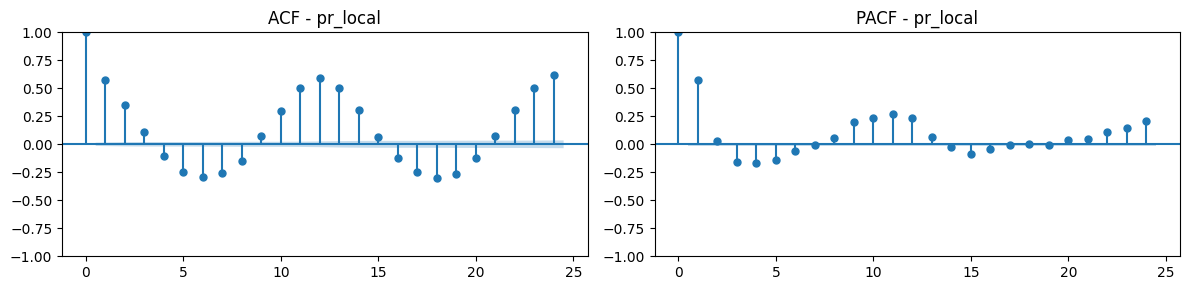

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supondo que o df_aesa_to_cnrm_cm6_1hr já está carregado

# Selecionar colunas relevantes para análise
cols = ['pr_local', 'pr_mes_anterior', 'pr_acum_3m', 'pr_acum_6m', 'pr_acum_12m']

# 1. Matriz de correlação e heatmap
corr = df_aesa_to_cnrm_cm6_1hr[cols].corr()

# 2. Gráficos de autocorrelação da variável pr_local (target)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plot_acf(df_aesa_to_cnrm_cm6_1hr['pr_local'].dropna(), lags=24, ax=plt.gca())
plt.title('ACF - pr_local')

plt.subplot(1,2,2)
plot_pacf(df_aesa_to_cnrm_cm6_1hr['pr_local'].dropna(), lags=24, ax=plt.gca())
plt.title('PACF - pr_local')

plt.tight_layout()
plt.show()


In [189]:
# Abrindo base de dados para configuração
df_aesa_to_cnrm_cm6_1hr = pd.read_csv(f'../datas/interim/4.3.2_create_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling.csv')

# Adicionando coluna de atraso (lag) de um mes da precipitação
df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{1}'] = df_aesa_to_cnrm_cm6_1hr.groupby('pnt')['pr'].shift(1)
df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{1}'] = df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{1}'].fillna(df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{1}'].mean())

# Adicionando coluna de atraso (lag) de um mes da precipitação
df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{6}'] = df_aesa_to_cnrm_cm6_1hr.sort_values(['pnt', 'ano', 'mes']).groupby('pnt')['pr'].rolling(window=3).sum().reset_index(0, drop=True)
df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{6}'] = df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{6}'].fillna(df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{6}'].mean())

# Adicionando coluna de atraso (lag) de um mes da precipitação
df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{12}'] = df_aesa_to_cnrm_cm6_1hr.sort_values(['pnt', 'ano', 'mes']).groupby('pnt')['pr'].rolling(window=3).sum().reset_index(0, drop=True)
df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{12}'] = df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{12}'].fillna(df_aesa_to_cnrm_cm6_1hr[f'pr_lag_{12}'].mean())

# Adicionando coluna de agrupamento de dados
df_coords = df_aesa_to_cnrm_cm6_1hr[['lat', 'lon']].drop_duplicates()
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_coords)
df_coords['cluster'] = kmeans.labels_
df_aesa_to_cnrm_cm6_1hr = df_aesa_to_cnrm_cm6_1hr.merge(df_coords, on=['lat', 'lon'], how='left')

# Salvando nova base de dados gerada
if databases_generate:
    df_aesa_to_cnrm_cm6_1hr.to_csv(f'../datas/interim/4.3.3_finish_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling_complete.csv')

# Limpando avisos
clear()

# Informações da base de dados com novas features
df_aesa_to_cnrm_cm6_1hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64200 entries, 0 to 64199
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  64200 non-null  int64  
 1   lat         64200 non-null  float64
 2   lon         64200 non-null  float64
 3   ano         64200 non-null  int64  
 4   mes         64200 non-null  int64  
 5   pr_local    18000 non-null  float64
 6   pnt         64200 non-null  object 
 7   pr          64200 non-null  float64
 8   IDW         64200 non-null  float64
 9   pr_lag_1    64200 non-null  float64
 10  pr_lag_6    64200 non-null  float64
 11  pr_lag_12   64200 non-null  float64
 12  cluster     64200 non-null  int32  
dtypes: float64(8), int32(1), int64(3), object(1)
memory usage: 6.1+ MB


### 4.3.4. Geração de Base de Dados de Redução de Escala

In [ ]:
# Media Geral

# Abrindo base de dados para predição
df_aesa_to_cnrm_cm6_1hr = pd.read_csv(f'../datas/interim/4.3.3_finish_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling_complete.csv')

# Colunas X e y
X_col, y_col = ['pr', 'pr_lag_1', 'pr_lag_6', 'pr_lag_12', 'cluster', 'ano', 'mes', 'lat', 'lon', 'IDW'], "pr_local"

# if idw_method == True:
#     X_col.append('IDW')

# Definindo ano que separará o treino e a predição
anos_X = [
    (1994, 2017), (1994, 2018), (1994, 2019), (1994, 2020), (1994, 2021),
]
anos_Y = [
    (2018, 2019), (2019, 2020), (2020, 2021), (2021, 2022), (2022, 2023),
]

# Supondo que sua função de predição já esteja definida:
models = []

models.append(persistence_forecasts(df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023]))

for model in predicao_por_ml(df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023], X_col, y_col, anos_X, anos_Y): models.append(model)

models.append(predicao_por_cnn(df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023], X_col, y_col, anos_X, anos_Y, 29))

models.append(predicao_por_lstm(df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023], X_col, y_col, anos_X, anos_Y, 29))

models.append(predicao_por_mlp(df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023], X_col, y_col, anos_X, anos_Y, 29))

print('Análise de Modelos:\n')

best_model, r = '', 0
for model in models:

    print(f"{model[0][:3]} \t Média r: {model[1]:.4f} \t Média RMSE: {model[2]:.4f} \t Média MAE: {model[3]:.4f}")

    if r <= model[1]:
        best_model = model[0]
        r          = model[1]

print(f'\nO melhor modelo é: {best_model}')

/tmp/ipykernel_1658456/2767001175.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['series_id'] = df['lat'].astype(str) + '_' + df['lon'].astype(str)


In [ ]:
# Abrindo base de dados para predição
df_aesa_to_cnrm_cm6_1hr = pd.read_csv(f'../datas/interim/4.3.3_finish_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling_complete.csv')

# Fixando seed
fix_seed(58)

# Configurando base de dados
X_train = df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023][X_col].values
y_train = df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023][y_col].values

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Redimensionar para 3D: (samples, timesteps=1, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Criando modelo CNN
cnn = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(1),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Treinamento
cnn.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=0)

# Salvando modelo
if databases_generate:
    cnn.save('../models/statistical_downscaling.h5')

# Configurando base de dados para predição
X_pr_local = df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] > 2023][X_col].values

# Normalizando dados de predição
X_pr_local = scaler.transform(X_pr_local)

# Redefinindo escala dos dados
X_pr_local = X_pr_local.reshape((X_pr_local.shape[0], 1, X_pr_local.shape[1]))

# Previsão dos valores de 'pr' com o modelo treinado
pr_local = cnn.predict(X_pr_local).flatten()

# Adicionando a nova coluna 'pr' ao DataFrame
df_aesa_to_cnrm_cm6_1hr.loc[df_aesa_to_cnrm_cm6_1hr[y_col].isnull(), y_col] = pr_local

# Exportando base de dados para CSV
if databases_generate:
    df_aesa_to_cnrm_cm6_1hr.to_csv(f'../datas/processed/4.3.4_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling_database.csv')

# Informações da base de dados predita
df_aesa_to_cnrm_cm6_1hr.info()

1444/1444 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64200 entries, 0 to 64199
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0.1     64200 non-null  int64  
 1   Unnamed: 0       64200 non-null  int64  
 2   lat              64200 non-null  float64
 3   lon              64200 non-null  float64
 4   ano              64200 non-null  int64  
 5   mes              64200 non-null  int64  
 6   pr_local         64200 non-null  float64
 7   pnt              64200 non-null  object 
 8   pr               64200 non-null  float64
 9   IDW              64200 non-null  float64
 10  pr_mes_anterior  64200 non-null  float64
 11  pr_acum_6m       64200 non-null  float64
 12  cluster          64200 non-null  int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 6.4+ MB


### 4.3.5. Geração de Modelo Preditivo Final de Interpolação de Base de Dados de Redução de Escala

In [136]:
df_aesa_to_cnrm_cm6_1hr = pd.read_csv(f'../datas/processed/4.3.4_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling_database.csv')

df_baseline_idw = df_aesa_to_cnrm_cm6_1hr[df_aesa_to_cnrm_cm6_1hr['ano'] <= 2023][['lat', 'lon', 'ano', 'mes', 'pr_local']]

df_baseline_idw = calcular_precipitacao_idw(df_baseline_idw, "pr_local", "lat", "lon", "ano", "mes")

r = np.corrcoef(df_baseline_idw['pr_local'], df_baseline_idw['IDW'])[0, 1]
rmse = np.sqrt(mean_squared_error(df_baseline_idw['pr_local'], df_baseline_idw['IDW']))

print('\nVerificação de Modelo Base:\n')
print(f'Modelo: IDW \t r: {r:.4f} \t RMSE: {rmse:.4f}')

[━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━] 100.00% (18000 de 18000)

Verificação de Modelo Base:

Modelo: IDW 	 r: 0.9598 	 RMSE: 24.3612


In [17]:
df_aesa_to_cnrm_cm6_1hr = pd.read_csv(f'../datas/processed/4.3.4_downscaling_database/aesa_to_cnrm_cm6_1hr_{database_type}_downscaling_database.csv')

# Colunas X e y
X_col, y_col = ['ano', 'mes', 'lat', 'lon'], "pr_local"

# Escolhendo melhor modelo preditivo
model = interpolacao_por_ml(df_aesa_to_cnrm_cm6_1hr, X_col, y_col, "pnt", 5)

# Definindo features (X) e variável alvo (y)
X = df_aesa_to_cnrm_cm6_1hr[X_col].copy()
y = df_aesa_to_cnrm_cm6_1hr[y_col].copy()

# Treinamento
model.fit(X, y)

# Salvando o modelo
if databases_generate:
    joblib.dump(model, f'../models/statistical_downscaling_spatialization.joblib', compress=3)

Verificação de Modelos:

Modelo: Ext 	 r: 0.9839 	 RMSE: 15.4709
Modelo: Ran 	 r: 0.9779 	 RMSE: 18.0213
Modelo: Lin 	 r: 0.7936 	 RMSE: 52.4367

O melhor modelo de ML para a base de dados é: ExtraTrees.
